# Jeremiah Lowhorn
# INFS 770 Spring Assignment 1
# 2/4/2019

# Task 2

Classification using scikit-learn and pandas 

[Dataset: magic04.csv]

https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope

For this problem you will experiment with various classifiers provided as part of the scikit-learn (sklearn) machine learning module, as well as with some of its preprocessing and model evaluation capabilities.  The data is provided in a CSV formatted file with the first row containing the attribute names. Click “Data Folder”, and you can download the dataset to your PC by right-clicking and then selecting “save link as” the magic04.data link. The description of the different fields in the data is provided at http://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names.
In this assignment, you need to use the scikit-learn package, the main machine learning package in python. Please take a look at the scikit-learn home page (http://scikit-learn.org/stable/index.html) to get an overview of the package.
You want to make sure the scikit-learn package you are using is the latest one (v20). If you installed anaconda recently, you should have the latest version. If you plan to use pycharm + canopy, please go to canopy command line and type “pip install –U scikit-learn” just to make sure you have the latest version of scikit learn.
Please write a ipython notebook to finish the following tasks. You probably want to finish the task by modifying the German credit notebook.

## Importing Libraries

In [30]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import multiprocessing
import matplotlib.pyplot as plt
from sklearn import preprocessing
print(multiprocessing.cpu_count())
### do not use all cores
n_cores = 50
import seaborn as sns

256


## Reading Data

In [31]:
nms = ['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fMTrans','fAlpha','fDist','class']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data',names=nms)

In [32]:
##everything checks out here
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fMTrans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [33]:
##correct types were read in
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
fLength    19020 non-null float64
fWidth     19020 non-null float64
fSize      19020 non-null float64
fConc      19020 non-null float64
fConc1     19020 non-null float64
fAsym      19020 non-null float64
fM3Long    19020 non-null float64
fMTrans    19020 non-null float64
fAlpha     19020 non-null float64
fDist      19020 non-null float64
class      19020 non-null object
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


In [34]:
##no na/null values in the dataset
df.isnull().any().any()

False

## Splitting Data into Training And Test Sets
We also want to scale the data here because the SVM algorithm is sensitive to the data all being on the same scale for the hyperplane. 

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
df, df['class'], random_state=42, test_size = 0.35)

X_train = X_train.drop(['class'], 1)
X_test = X_test.drop(['class'], 1)

X_train = np.array(X_train)
X_train = preprocessing.scale(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
X_test = preprocessing.scale(X_test)
y_test = np.array(y_test) 

## Logistic Regression

### Hyperparameter Tuning - L2 Regularization
With a lambda value of 1 no regularization is needed for this model. 

In [36]:
#tuning lambda for regularization
lambdaval = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1]

lamda_grid = {'C': lambdaval}

logreg = LogisticRegression(class_weight='balanced',penalty='l2',solver='liblinear')
logsearch = GridSearchCV(estimator = logreg, param_grid  = lamda_grid, cv = 10,
                                n_jobs = n_cores
                              )
logsearch.fit(X_train, y_train)

logsearch.best_params_

{'C': 0.005}

### Building the Model

In [37]:
mod1 = LogisticRegression(**logsearch.best_params_,solver='liblinear',class_weight='balanced').fit(X_train, y_train)

### Printing the Accuracy - Inside a Confusion Matrix

In [38]:
score1 = mod1.score(X_test, y_test)

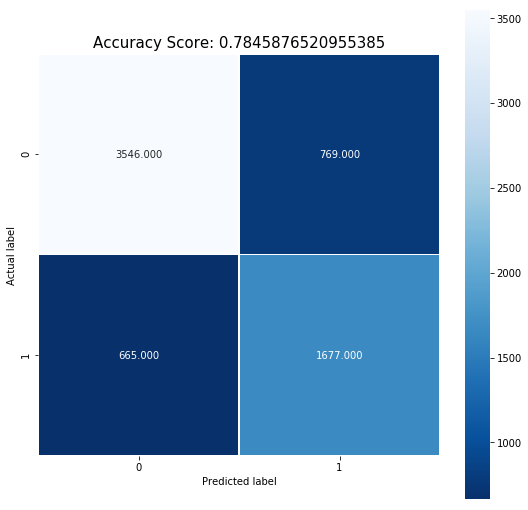

In [39]:
predictions = mod1.predict(X_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score1)
plt.title(all_sample_title, size = 15);

### Extract the Coefficients 
I use this to determine what variables attribute to the model; in this case fConc and fConc1 seem sto have the largest impact on the log odds of g vs h. We may see similar accuracy from just using two or three of the most important features, especially considering our grid search thought that not using regularization was the best outcome, but that seems out of scope for this assignment. 

In [40]:
print('Logistic Regression Intercept: ' + str(mod1.intercept_[0]))

Logistic Regression Intercept: -0.06953775027194224


In [41]:
coef_dict = {}
for coef, feat in zip(mod1.coef_[0,:],df):
    coef_dict[feat] = coef
print("Logistic Regression Coefficients: ")
coef_dict

Logistic Regression Coefficients: 


{'fLength': 0.8168691664000232,
 'fWidth': 0.23827521821347628,
 'fSize': 0.22714268908415264,
 'fConc': 0.18139949938391514,
 'fConc1': 0.3352775247874215,
 'fAsym': -0.08635412912651165,
 'fM3Long': -0.2559924035438201,
 'fMTrans': -0.00048284289441027033,
 'fAlpha': 1.033551727497531,
 'fDist': 0.05649740577071855}

### Classification Report

In [42]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           g       0.84      0.82      0.83      4315
           h       0.69      0.72      0.70      2342

   micro avg       0.78      0.78      0.78      6657
   macro avg       0.76      0.77      0.77      6657
weighted avg       0.79      0.78      0.79      6657



## SVM

### Hyperparameter Tuning

In [43]:
lambdaval = [0.001,0.01,0.1,1]
kernel = ['linear','rbf']


svm_grid = {'C': lambdaval,
             'kernel':kernel}

svm = SVC()
svmsearch = GridSearchCV(estimator = svm, param_grid  = svm_grid, cv = 3,
                                n_jobs = n_cores
                              )
svmsearch.fit(X_train, y_train)

svmsearch.best_params_

{'C': 1, 'kernel': 'rbf'}

In [44]:
mod2 = SVC(**svmsearch.best_params_).fit(X_train, y_train)

### Print the Accuracy - Inside a Confusion Matrix
The SVM algorithm is much more accurate than the logistic regression model because we preprocessed and scaled the data appropriately. Had we not rescaled the data the accuracy between the two methods probably would not be vastly different. 

In [45]:
score2 = mod2.score(X_test, y_test)

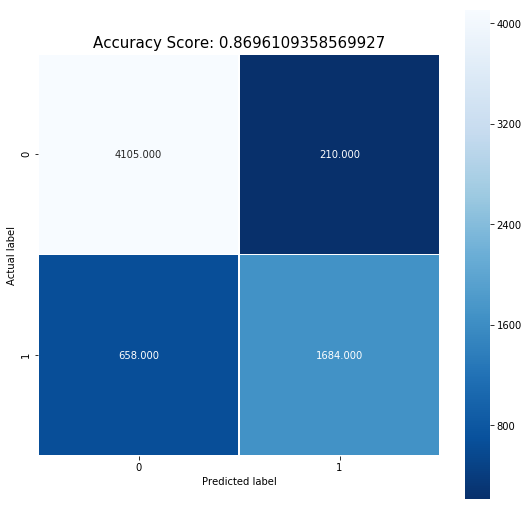

In [46]:
predictions = mod2.predict(X_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score2)
plt.title(all_sample_title, size = 15);

In [47]:
print(score2 > score1)
print(score2 - score1)

True
0.08502328376145418


### Classification Report

In [48]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           g       0.86      0.95      0.90      4315
           h       0.89      0.72      0.80      2342

   micro avg       0.87      0.87      0.87      6657
   macro avg       0.88      0.84      0.85      6657
weighted avg       0.87      0.87      0.87      6657



# Part 4
### 1)	Please use your own language to describe the SVM algorithm (5-10 sentences)
### 2)	Please use your own language to describe how soft margin svm is different from hard-margin SVM.(<=3 sentences)
### 3)	Why do you often need to use kernels in SVM? (<3 sentences)


## 1
A support vector machine is a classification algorithm that uses a hyperplane to separate the class. The data is transformed via a kernel function to make the data seperatable by a hyperplane. The hyperplane can be n-dimensional based upon the number of features in the data. There are different kernels for different types of hyperplanes and parameters that control the complexity of the hyperplane. For example, a linear kernel function would simply draw a line in a two dimensional space to split the data. Regularization and gamma parameters are important for tuning the SVM. Regularization follows the same principal in other models in that a lambda value penalizes certain features so that they do not overfit the model which will help it generalize better on new data. Essentially for larger values of C the SVM optimizer will choose a smaller-margin hyperplane to get all of the points correctly classified; for lower values of C the algorithm will find a larger-margin hyperplane. The gamma value allows for smoothing of the rbf and polynomial kernel; higher values of gamma allow for more smoothing while lower values create more jagged hyperplanes that try to classify every point, even if it is an outlier. A big assumption that is often missed is that the training data is on the same scale. This important for the transformation to make the data linearly seperable. 

## 2
Hard margin SVMs essentially result in fitting models that allow zero errors whereas soft margins allows for errors to be made in the fitting processs. Soft margins allow for a more generalizable model where hard margins can allow the algorithm to fit perfectly to the data even in the presence of outliers. 

## 3
Kernels allow for fitting different hyperplanes to the data. For example if the data, once transformed is linearly seperable the linear kernel would fit a linear hyperplane to the data. However, if the separation is not clearly linear, maybe circular, the rbf kernel would allow the creation of a hyperplane that is circular in nature with the appropriate gamma. Conversley, if the hyperplane is quadratic, a linear kernel would not work as well as a polynomial kernel.  